<a href="https://colab.research.google.com/github/otluiz/Covid-19_kaggle/blob/master/Copy_of_Covid_19_Kaggle_Textos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np
import zipfile
import pandas as pd
import glob
import json
import seaborn as sns
import spacy
import nltk
from IPython.core.display import HTML
from matplotlib import pyplot as plt

In [ ]:
#!pip install -U spacy
#!python -m spacy download en
#!pip install scispacy
import scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_core_sci_md-0.2.5.tar.gz
import en_core_sci_md
import zipfile

Chama os drives da Google e monta um novo diretório neste 'notebook'. Precisa de uma conexão (URL) onde a Google gera uma 'auth' para entrar no meu Google Drive

First, you'll need to mount your Drive.

In [46]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Conecta ao diretório do meu Google Drive onde estão os dados da Covid-19 que está compactado.
Será descompactado (unzip) no meu Google Drive


In [47]:
path = '/content/gdrive/My Drive/CORD-19-research-challenge.zip'
from zipfile import *
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

Criação do DataFrame com os textos dos artigos


DataFrame no formato JSON

In [48]:
features_corona = {'paper_id': [],
                   'title' : [],
                   'abstract' : [],
                   'text' : []}

Testando o tipo "features_corona"


In [10]:
type (features_corona)

dict

Transformar o tipo dict em dataframe


In [49]:
corona_df = pd.DataFrame.from_dict(features_corona)

Verificando o novo tipo

In [50]:
type (corona_df)

pandas.core.frame.DataFrame

Pandas é o "default for Machine Learning in Python projects"


In [ ]:
corona_df.head()

Ler os arquivos JSON a partir da raiz '/' para popular o futuro dataframe (corona_df) a ser criado mais adiante


In [ ]:
json_filenames = glob.glob(f'{"./"}//**/*.json', recursive = True)
print(json_filenames)

In [53]:
json_filenames)

29316

Cada arquivo JSON seráá uma linha do dataframe, populando assim o corona_df


In [54]:
def retorna_corona_df(json_filenames, df):
  for file_name in json_filenames:
    linha_dados = {'paper_id': None, 'title': None, 'abstract': None, 'text': None}

    with open(file_name) as json_data:
      if file_name == './sample_data/anscombe.json': # ignora os anscombe.json
        continue
      #if file_name == './MeuMestrado/ProjetoGeolocalização/node_modules/gulp/node_modules/tildify/*.json': 
      #  continue

      data = json.load(json_data)

      ## .strip() : ' 345 ' -> '345' retira os espaços
      linha_dados['paper_id'] = data['paper_id'].strip()
      linha_dados['title'] = data['metadata']['title'].strip()

      abstract_list = [abstract['text'] for abstract in data['abstract']]
      abstract = '\n'.join(abstract_list)
      linha_dados['abstract'] = abstract.strip()

      text_list = [text['text'] for text in data['body_text']]
      text = '\n'.join(text_list)
      linha_dados['text'] = text.strip()

      df = df.append(linha_dados, ignore_index = True)
  return df

In [55]:
corona_df = retorna_corona_df(json_filenames, corona_df)

In [56]:
corona_df2 = corona_df[['paper_id', 'title', 'abstract', 'text']] ## criando um back-up do DataFrame


In [19]:
#corona_df.drop(corona_df.tail(29315).index,inplace=True) # remove as ultimas linhas

In [20]:
#corona_df.drop(corona_df.head(2).index,inplace=True) # drop first 2 rows

In [57]:
corona_df.shape

(29315, 4)

In [22]:
corona_df2.shape

(29315, 4)

In [ ]:
corona_df.tail() ## Mostra os últimas 5 linhas do Dataframe corona_df

In [ ]:
## Verificando a coluna tíítulo (title) do último registro (29314) do Dataframe
corona_df['title'][29314] 


In [ ]:
corona_df['text'][2]  ## Verificando a coluna 'text' do Dataframe

In [64]:
len(corona_df['text'][2]) ## Quantas palavras têm este texto [2]?

36685

**PERPROCESSAMENTO DE TEXTOS DOS ARTIGOS**
<PROCURANDO POR DADOS FALTANTES>

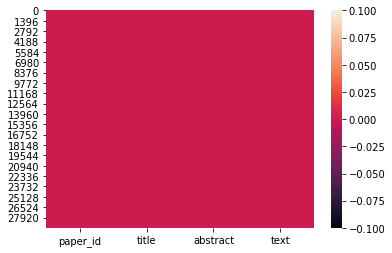

In [65]:
sns.heatmap(corona_df.isnull()); ## procurando dados faltantes pelo mapa de calor

In [66]:
len(corona_df[corona_df['paper_id'] == '']) # procurando por espaços vazios

0

In [67]:
len(corona_df[corona_df['title'] == '']) # procurando por espaços vazios nos tíítulos

3583

In [68]:
len(corona_df[corona_df['abstract'] == '']) # procurando por espaços vazios nos abstracts

8051

In [32]:
len(corona_df[corona_df['text'] == '']) # procurando por espaços vazios nos textos

0

In [69]:
corona_df = corona_df[corona_df['title'] != ''] ## apagando os artigos sem tíítulos

In [72]:
corona_df = corona_df[corona_df['abstract'] != ''] ## apagando os artigos sem abstract

**REMOVENDO ARTIGOS DUPLICADOS**

In [76]:
corona_df.drop_duplicates(['abstract', 'text', 'title'], inplace=True)

In [77]:
corona_df_bck = corona_df  ## reafzendo tudo porra!!

In [78]:
corona_df.shape ## o que sobrou após a limpeza??

(20211, 4)

In [79]:
corona_df_bck.shape  ## vendo quem mandou 2 ou mais vezes o mesmo artigo - ahaha

(20211, 4)

**BASE DE DADOS DE AMOSTRA**


In [80]:
corona_df = corona_df.sample(n = 500, random_state=1)

In [81]:
corona_df.shape

(500, 4)

In [ ]:
corona_df.head()

In [ ]:
corona_df.tail()

In [ ]:
## Visual Text analisys
sample_text = corona_df['text'][23192]
sample_text

**FUNÇÃO PARA PREPROCESSAMENTO**


In [85]:
#nlp = spacy.load('en')
#nlp = spacy.load('en_core_sci_md')
nlp = en_core_sci_md.load(disable=['tagger', 'parser', 'ner'])

nlp.max_length = 2000000

In [ ]:
#print('scispacy:', scispacy.__version__, " - ", "spacy:", spacy.__version__)
#!stopwnltk = nltk.corpus.stopwords.words("english")

In [86]:
print(spacy.lang.en.stop_words.STOP_WORDS)

{'yours', 'ever', 'via', 'whatever', 'whom', 'therein', 'their', 'call', 'may', 'somewhere', 'she', 'but', 'anyone', 'however', 'is', 'this', 'they', 'cannot', 'five', 'formerly', 'one', 'without', 'themselves', 'back', 'down', 'everything', 'herself', 'moreover', 'just', 'or', 'made', 'see', 'am', 'somehow', 'onto', 'someone', 'than', 'though', 'whereafter', 'next', 'amount', 'that', 'from', 'bottom', 'here', 'least', '’re', 'no', 'during', 'should', 'have', 'former', 'afterwards', 'doing', 'were', 'why', 'eight', 'does', 'almost', 'become', 'behind', 'alone', 'always', 'perhaps', 'about', 'became', '’d', 'do', 'has', 'after', 'nevertheless', "n't", 'before', 'him', 'neither', 'did', 'who', 'please', 'its', 'yet', 'throughout', 'first', 'many', 'whither', 'along', 'could', 'hereafter', 'mostly', 'above', 'using', 'whereas', 'thereupon', 'hence', 'make', 'below', 'he', 'together', '‘s', 'sixty', 'hundred', 'ourselves', 'well', 'by', 'upon', 'used', 'hereby', 'anywhere', '‘re', 'mine', 

In [90]:
len(spacy.lang.en.stop_words.STOP_WORDS)

326

In [134]:
def spacy_tokenizer(sentence):
  sentence = sentence.lower() ## coloca tudo em minúsculo
  list = [] 
  list = [word.lemma_ for word in nlp(sentence) if not (word.is_stop)] ## disable=['tagger', 'parser', 'ner']
  lsit = ' ' .join([str(element) for element in list])

  return list

In [ ]:
test = sample_text
result = spacy_tokenizer(test)
result

In [125]:
token_list = []
## junta as palavras numa mesma linha
def join_sentences(textos):
  token_list = ' '.join([token_list for token_list in textos])
  return token_list

In [133]:
sample_text

'The patient is a 22-year-old man with a history of common variable immunodeficiency (CVID) associated with a heterozygous mutation in TNFRSF13B (TACI), granulomatous lymphocytic interstitial lung disease (GLILD), massive splenomegaly, immune thrombocytopenia, and autoimmune hemolytic anemia. He presented with a 5-day history of fever with temperatures up to 38.9 C, malaise, sinus congestion, intermittent headaches, and loose stools. He had no cough, dyspnea, vomiting, abdominal pain, joint pain, or rash. He had been nonadherent with his weekly home dosing of subcutaneous immunoglobulin therapy for hypogammaglobulinemia because he reported only taking a total of 3 doses during the previous 3 months, with the most recent dose 4 days before presentation. He had been treated with immunoglobulin replacement since 10 years of age when CVID was diagnosed based on a clinical history of recurrent sinus and ear infections, low pretreatment immunoglobulin levels (IgG, 291 mg/dL; IgA, 18.7 mg/dL;

In [135]:
test = sample_text
result = join_sentences(spacy_tokenizer(test))
result

'patient 22-year-old man history common variable immunodeficiency ( cvid ) associate heterozygous mutation tnfrsf13b ( taci ) , granulomatous lymphocytic interstitial lung disease ( glild ) , massive splenomegaly , immune thrombocytopenia , autoimmune hemolytic anemia . present 5-day history fever temperature 38.9 c , malaise , sinus congestion , intermittent headache , loose stool . cough , dyspnea , vomit , abdominal pain , joint pain , rash . nonadherent weekly home dose subcutaneous immunoglobulin therapy hypogammaglobulinemia report take total 3 dose previous 3 month , recent dose 4 day presentation . treat immunoglobulin replacement 10 year age cvid diagnose base clinical history recurrent sinus ear infection , low pretreatment immunoglobulin level ( igg , 291 mg/dl ; iga , 18.7 mg/dl ; igm , 31 mg/dl ) , poor specific antibody response vaccine . 14 year age treat 4 weekly dose rituximab improvement chronic thrombocytopenia , reduction splenomegaly , radiographic resolution lung 

In [ ]:
corona_df['text'] = corona_df['text'].apply(spacy_tokenizer)

In [ ]:
print(sample_text)

In [ ]:
len(sample_text)

In [ ]:
print(corona_df['text'][11015])